In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('max_style.mplstyle')

In [2]:
import matplotlib.patches as patches

In [3]:
import sys
sys.path.insert(0, './../PySITCONS/')
from PySITCONS.core.trap import red_system
redgeo = np.load('./../PySITCONS/PySITCONS/trap_geometries/sitcons_redtrap.npy')

In [4]:
redsys = red_system(redgeo)

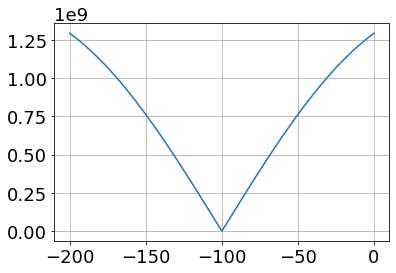

In [9]:
x = np.linspace(-200e-6, 0, 1000)

voltage = np.zeros((16, 1))
voltage[15, 0] = -1
redsys.volt = voltage

#plt.plot(x, redsys.getPot(x))
redsys.interaction = False
plt.plot(x*1e6, np.abs(redsys.getAcc(x)))
#redsys.getPot(np.array([100e-6]), 0)
redsys.interaction = True

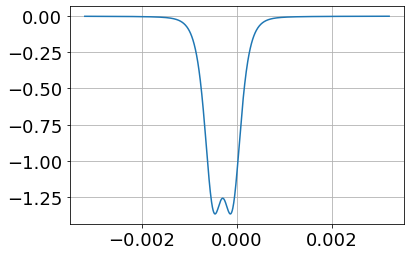

In [6]:
x = np.linspace(-32e-4, 32e-4, 1000)

voltage = np.zeros((16, 1))
voltage[13, 0] = -6
voltage[14, 0] = 0
voltage[15, 0] = -6
redsys.volt = voltage

#plt.plot(x, redsys.getPot(x))
redsys.interaction = False
plt.plot(x, redsys.getPot(x))
#redsys.getPot(np.array([100e-6]), 0)
redsys.interaction = True

# ----------------------

In [7]:
np.array([-500, -500])*1e-6

array([-0.0005, -0.0005])

In [8]:
voltage = np.zeros((16, 1))
voltage[13, 0] = -6
redsys.volt = voltage

erg = minimize(lambda t: redsys.getAcc(np.array([-500-t[0], -500+t[0]])*1e-6)[0]**2, 
               x0=1., 
               tol=1e-5,
               #bounds= [[0.0001, 5]]
              )

if erg['success']:
    print(erg['x'])

else:
    print(erg)

      fun: 4.4839172220599375
 hess_inv: array([[5.94670019e-18]])
      jac: array([24870481.54495096])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 6
     njev: 17
   status: 2
  success: False
        x: array([0.44801901])


In [9]:
voltage = np.zeros((16, 1))
voltage[13, 0] = -6
redsys.volt = voltage

redsys.interaction = True
x = np.linspace(3e-7, 1e-6, 1000)
y = [np.sum(np.abs(redsys.getAcc(np.array([-500e-6-t, -500e-6+t])))) for t in x]

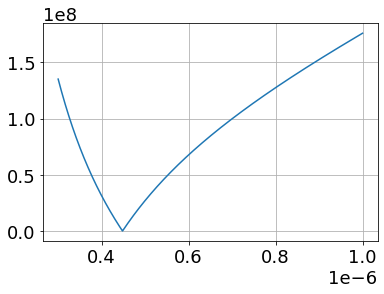

In [10]:
plt.plot(x, y)

# Find equilibrium position

In [11]:
redsys = red_system(redgeo)

voltage = np.zeros((16, 1))
voltage[13, 0] = -6
redsys.volt = voltage

erg = minimize(lambda x: np.sum(redsys.getAcc(x*1e-6)**2), 
               np.array([-501, -499]), 
               tol=1e-10,
               bounds=[[-505, -495], [-505, -495]])

erg

      fun: 11.679616740009312
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1007.55331553, 2706.48798793])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 14
     njev: 21
   status: 0
  success: True
        x: array([-500.44805277, -499.55204846])

In [37]:
redsys.interaction = True

voltage = np.zeros((16, 1))
voltage[13, 0] = -6
redsys.volt = voltage

redsys.getAcc(np.array([-500.44801901e-6, -499.55198099e-6]))
#redsys.getAcc(np.array([-499.552e-6, -500.448e-6]))
np.sqrt(redsys.getPotcurv(np.array([-500e-6]))) / (2*np.pi)

array([1564770.16307919])

In [13]:
voltage = np.zeros((16, 1))
redsys = red_system(redgeo)
redsys.interaction = True

In [51]:
%%time

erg = []
x0 = np.array([-6, -6, -6]) # , 10)
bounds = ((-6, 0), (-6, 0), (-6, 0))

transporttime = 50e-6
b = 2 * np.pi / transporttime
a = 199.552e-6 / 2 / np.pi

test = []
curv = []

redsys.interaction = False

def F_3(x, pos):
    voltage[11, 0] = x[2]
    voltage[12, 0] = x[1]
    voltage[13, 0] = x[0]
    voltage[14, 0] = x[1]
    voltage[15, 0] = x[2]
    redsys.volt = voltage
    
    return redsys.getPotcurv(pos)[1] / (2*np.pi) - 25e10

for i in np.linspace(0, transporttime, 101):
    x0 = np.array([-6 * (1 - i / transporttime)**10, -6 * (i / transporttime)**2, -6 * (i / transporttime)**2])
    # get x point
    lpos = i * b * a - a * np.sin(b * i)
    pos = np.array([-lpos-500.448e-6, lpos - 499.552e-6])
    
    def mini(x, pos, i):
        voltage[11, 0] = x[2]
        voltage[12, 0] = x[1]
        voltage[13, 0] = x[0]
        voltage[14, 0] = x[1]
        voltage[15, 0] = x[2]
        redsys.volt = voltage
        
        weight_curv = (redsys.getPotcurv(pos)[1] / (2*np.pi) - 25e10)**2 / 1e10
        
        #return (redsys.getAcc(pos)[1] - a * b**2 * np.sin(b * i))**2 #+ weight_curv
        return (redsys.getAcc(pos) + a * b**2 * np.sin(b * i))[0]**2 +\
                (redsys.getAcc(pos) - a * b**2 * np.sin(b * i))[1]**2

    erg += [minimize(mini,
                     x0,
                     args=(pos, i),
                     #constraints={'type': 'ineq', 'fun': F_3, 'args': (pos,)},
                     bounds=bounds,
                     tol=1e-20)['x']]
    
    #test += [np.sqrt(np.abs(redsys.getPotcurv(pos))) / (2*np.pi)]
    #test += [redsys.getPotcurv(pos)[1]]
    #test += [pos]
    #test += [redsys.getAcc(pos)]
    #test += [mini(erg[-1], pos , i)]
    curv += [np.sqrt(redsys.getPotcurv(pos)) / (2*np.pi)]
    
    #x0 = np.array([-6, -6]) * np.array([1 - i/100, i/100]) #
    #x0 = np.array(erg[-1])
    
    #bounds = ((-20, 0), (-20, 0), (-20, 20))
    
redsys.interaction = False
test = np.array(test).T
curv = np.array(curv)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt


Wall time: 2.86 s


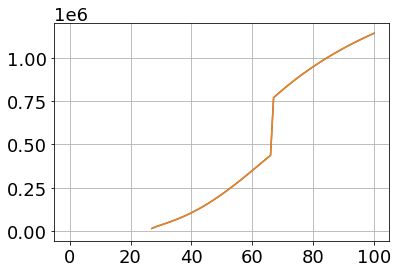

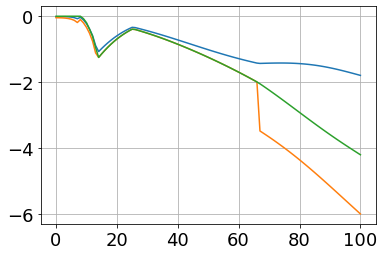

In [52]:
plt.plot(curv)
plt.show()
plt.plot(erg)

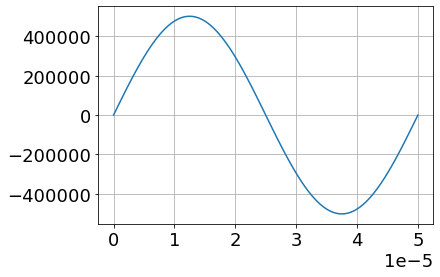

In [49]:
plt.plot(np.linspace(0, transporttime, 101), a * b**2 * np.sin(b * np.linspace(0, transporttime, 101)))

In [50]:
plt.plot(test[0])
plt.plot(-test[1])

IndexError: index 0 is out of bounds for axis 0 with size 0

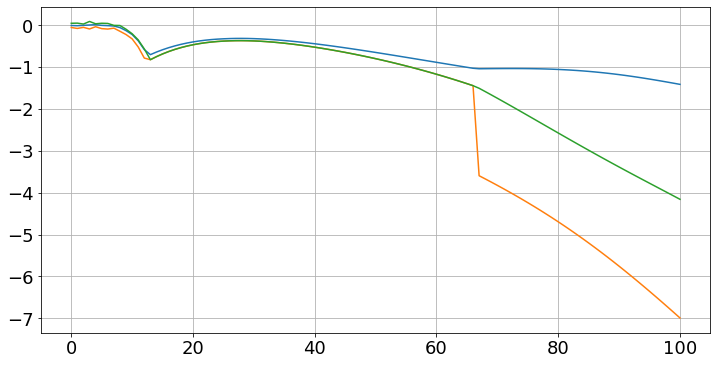

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(test[0])
#ax.plot(-test[1])
ax.plot(erg)

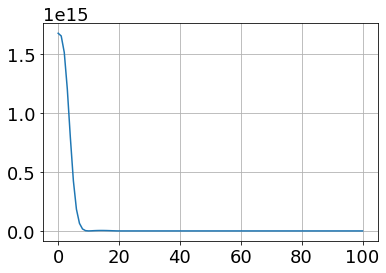

In [77]:
plt.plot(test)

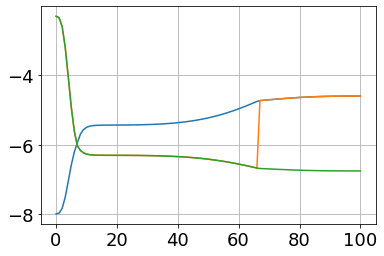

In [14]:
plt.plot(erg)

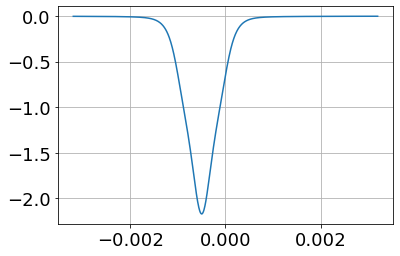

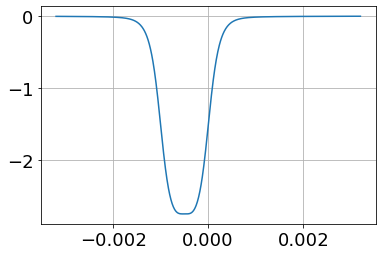

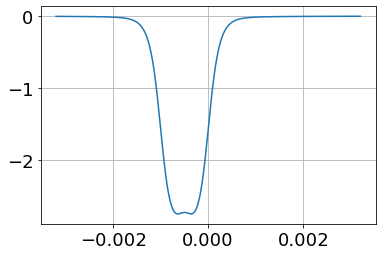

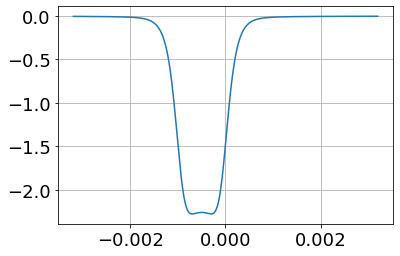

In [21]:
x = np.linspace(-32e-4, 32e-4, 1000)

for i in [0, 30, 60, 100]:
    p = erg[i]
    voltage = np.zeros((16, 1))

    voltage[11, 0] = p[2]
    voltage[12, 0] = p[1]
    voltage[13, 0] = p[0]
    voltage[14, 0] = p[1]
    voltage[15, 0] = p[2]

    redsys.volt = voltage

    #plt.plot(x, redsys.getPot(x))
    redsys.interaction = False
    plt.plot(x, redsys.getPot(x))
    plt.show()

In [16]:
def plot_trap(x, y):
    fig = plt.figure(figsize=(12, 6))

    ax = fig.add_axes([0, .15,  1, .7])

    ax_down = fig.add_axes([0, 0, 1, .15])
    ax_up = fig.add_axes([0,.85, 1,.15])


    ax.plot(x, y)

    ax_down.grid()
    ax_up.grid()
    ax_down.axis('off')
    ax_up.axis('off')
    ax.axis('off')

    #fig.suptitle("random axes")

    for i in range(32):
        origin = (i - 16) * 200e-6 + 20e-6

        rect = patches.Rectangle((origin, 0), 180e-6, 1, linewidth=1, facecolor='goldenrod')
        ax_up.add_patch(rect)

        rect = patches.Rectangle((origin, 0), 180e-6, 1, linewidth=1, facecolor='goldenrod')
        ax_down.add_patch(rect)

        if (i+1) % 4 == 0 and i < 31:
            ax_down.text(origin+90e-6, 0.8, str(i+1), fontsize=10, color='white', weight='bold', ha='center')
            ax_up.text(origin+90e-6, 0.1, str(i+1), fontsize=10, color='white', weight='bold', ha='center')

        #ax_down.text(0, -0.5, 'Segments', fontsize=20, weight='ultralight', ha='center')

        # generate longboi
        #======================================================================================
        corners = np.zeros((2, 4))

        corners[0] = np.concatenate([[0.00323, 0.00323], np.random.rand(2)/1e3+0.0035])
        corners[1] = np.concatenate([[0, 1], np.linspace(1, 0, 2)])
        cor = patches.Polygon(corners.T, facecolor='grey')
        ax_down.add_patch(cor)

        corners[0] = np.concatenate([[-0.00322, -0.00322], np.random.rand(2)/1e3-0.0045])
        cor = patches.Polygon(corners.T, facecolor='grey')
        ax_down.add_patch(cor)

        corners[0] = np.concatenate([[0.00323, 0.00323], np.random.rand(2)/1e3+0.0035])
        cor = patches.Polygon(corners.T, facecolor='grey')
        ax_up.add_patch(cor)

        corners[0] = np.concatenate([[-0.00322, -0.00322], np.random.rand(2)/1e3-0.0045])
        cor = patches.Polygon(corners.T, facecolor='grey')
        ax_up.add_patch(cor)

        #======================================================================================
        ax_up.set_xlim([-0.0045, 0.0048])
        ax_down.set_xlim([-0.0045, 0.0048])
        ax.set_xlim([-0.0045, 0.0048])

    #plt.tight_layout()
    plt.show()
    print('='*64)

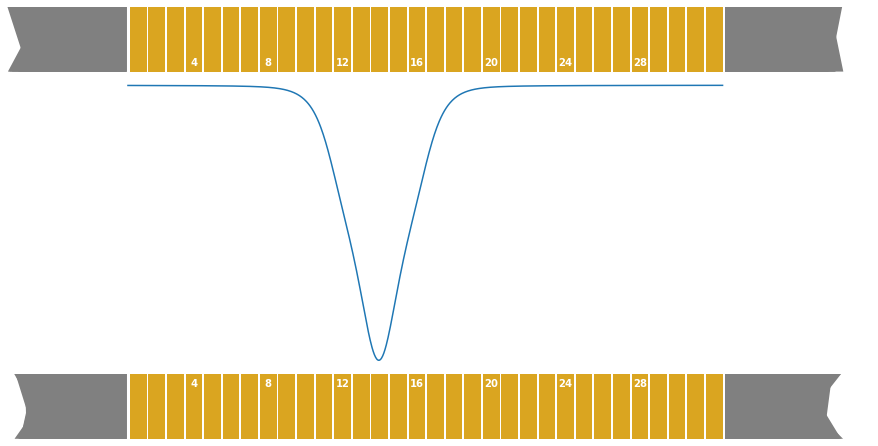

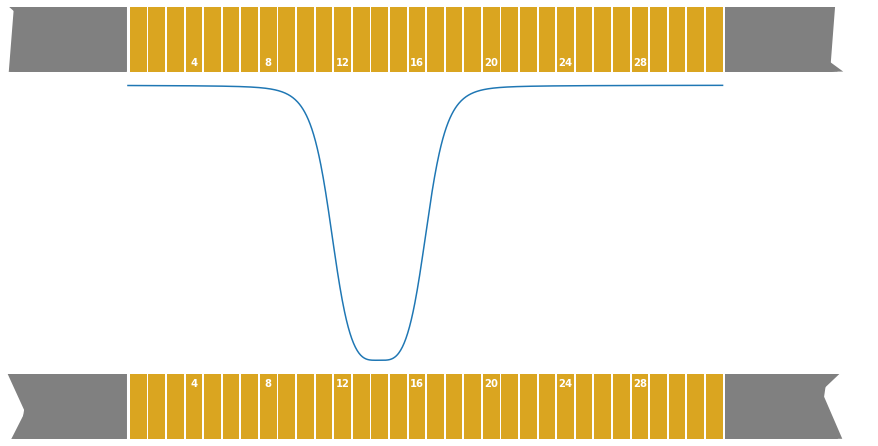

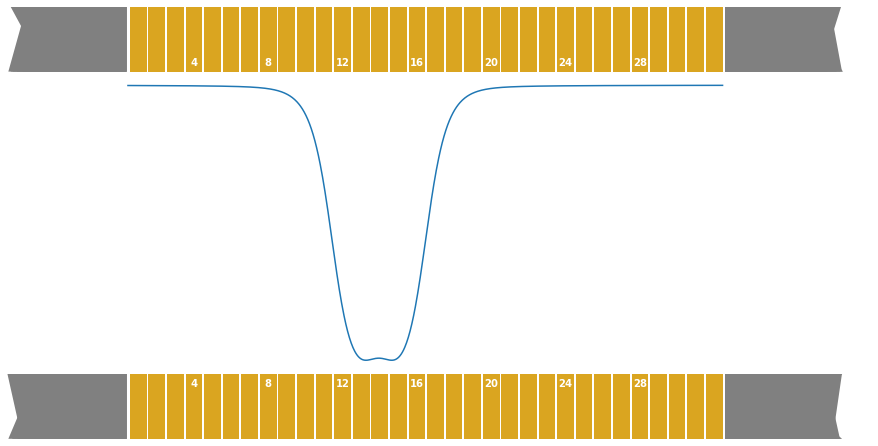

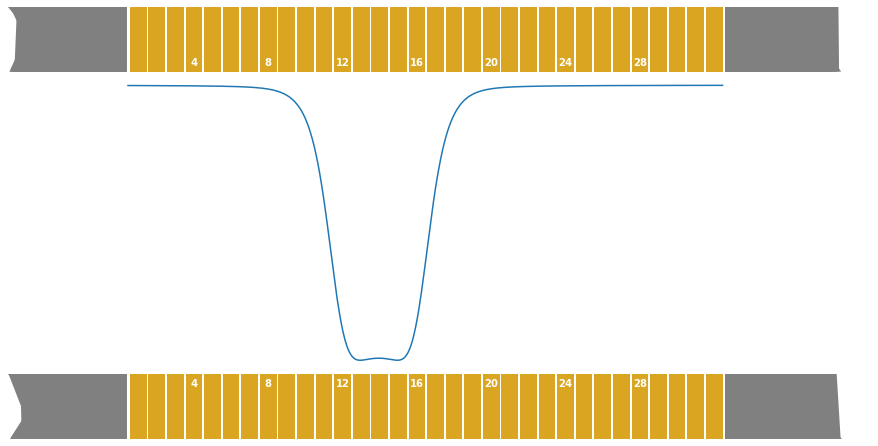

In [22]:
x = np.linspace(-32e-4, 32e-4, 1000)

for i in [0, 30, 60, 100]:
    p = erg[i]
    voltage = np.zeros((16, 1))

    voltage[11, 0] = p[2]
    voltage[12, 0] = p[1]
    voltage[13, 0] = p[0]
    voltage[14, 0] = p[1]
    voltage[15, 0] = p[2]

    redsys.volt = voltage

    #plt.plot(x, redsys.getPot(x))
    redsys.interaction = False
    plot_trap(x, redsys.getPot(x))
    plt.show()

In [ ]:
%%time

erg = []
x0 = (0, 0, -10)

transporttime = 50e-6
b = 2 * np.pi / transporttime
a = 199.552e-6 / 2 / np.pi

test = []

def F_3(x, pos):
    #print(pos)
    #return np.sum(x) - 5
    l = redsys.getDAcc(pos)[1]
    return np.sign(l)*np.sqrt(np.abs(l)) / (2*np.pi)

i = transporttime
# get x point
lpos = i * b * a - a * np.sin(b * i)
pos = np.array([-lpos-500.448e-6, lpos - 499.552e-6])
print(pos)

def mini(x, pos, i):
    voltage[11, 0] = x[2]
    voltage[12, 0] = x[1]
    voltage[13, 0] = x[0]
    voltage[14, 0] = x[1]
    voltage[15, 0] = x[2]
    redsys.volt = voltage
    return np.abs(redsys.getAcc(pos)[1] - a * b**2 * np.sin(b * i))

erg += [minimize(mini,
                 x0,
                 args=(pos, i),
                 #constraints={'type': 'ineq', 'fun': F_3, 'args': (pos,)},
                 bounds=((-20, 20), (-20, 20), (-20, 20)),
                 tol=1e-20)['x']]

test += [np.sqrt(np.abs(redsys.getDAcc(pos))) / (2*np.pi)]

erg

In [ ]:
redsys.interaction = True

x0 = (0, 0, 0)
voltage[11, 0] = x0[2]
voltage[12, 0] = x0[1]
voltage[13, 0] = x0[0]
voltage[14, 0] = x0[1]
voltage[15, 0] = x0[2]
redsys.volt = voltage

redsys.getAcc(np.array([-1e-6, 1e-6]))

In [ ]:
x = np.linspace(-501e-6, -499e-6, 100)
plt.plot(x*1e6, redsys.getAcc(x))

In [ ]:
lpos = i * b * a - a * np.sin(b * i)
pos = np.array([-lpos-500.448e-6, lpos - 499.552e-6])

In [ ]:
pos

In [2]:
1/10e-6/4

24999.999999999996